Importation des librairies

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from fcts.general import * 
from fcts.methode_seuil import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Téléchargement du jeu de données 

In [3]:
data = pd.read_csv("stars_train.csv")
X_test = pd.read_csv("stars_test.csv")

#On sépare les covariables et variable à prédire 
X = data[data.columns[0:-1]]
y = data[["label"]]

In [4]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.33, random_state=42)

In [4]:
g= sns.pairplot(data,hue = 'label', diag_kind= 'hist',vars=data.columns,plot_kws=dict(alpha=0.5), diag_kws=dict(alpha=0.5))
plt.show()

KeyboardInterrupt: 

On remarque que les catégories sont déséquilibrées, en effet on a beaucoup plus d'effectifs de la catégorie 

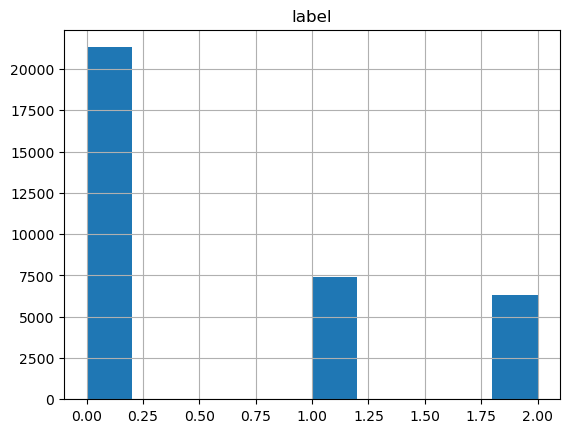

In [5]:
y_tr.hist()
plt.show()

On peut egalement apprécier une claire défintion des labels sur la variable redshift

On peut essayer d'utiliser les remarques du plot g. En effet, on remarque que la variable redshift contre alpha/delta permet de définir une claire frontière entre les trois classes. On peut envisager de calculer les valeurs (1-D) qui permettent de faire cette division sur la variable redshift. 

<Axes: xlabel='alpha', ylabel='redshift'>

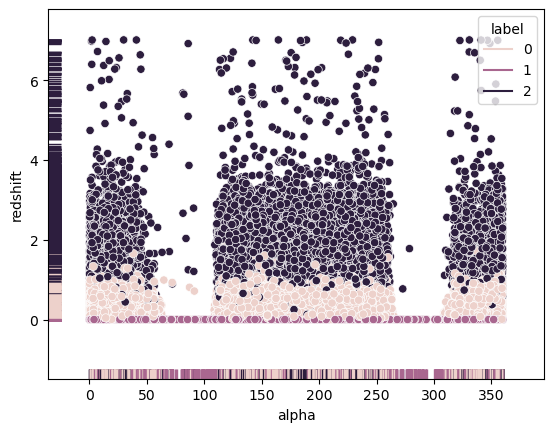

In [6]:
sns.scatterplot(data, x="alpha", y="redshift", hue = 'label')
sns.rugplot(data, x="alpha", y="redshift", hue = 'label')

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


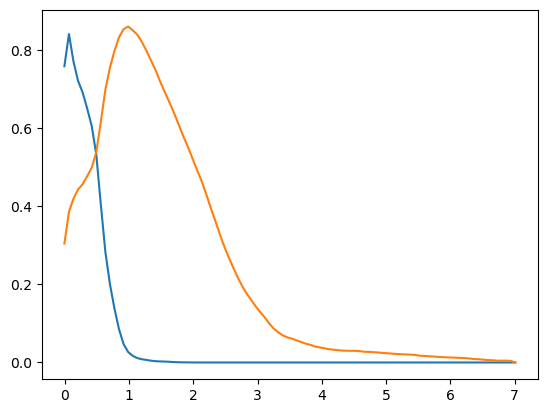

In [202]:
seuil_0,seuil_2 = choix_seuils(X,y,5,100, "redshift")

new_pred = Label_Encode(y_tr,pd.DataFrame(predict(seuil_0,seuil_2, X_te, "redshift")))

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


c_m = confusion_matrix(y_te.to_numpy(), new_pred) / confusion_matrix(y_te.to_numpy(), new_pred).sum()
print("Matrice confusion: ")
print(c_m)
print("")
taux_mal_classes = c_m[0,1:2] + c_m[1,0] + c_m[1,2] + c_m[2,0:1] + c_m[2,0:1]
print("taux_mal_classes: ", taux_mal_classes)
print("")
print("f1_score: ", f1_score(y_te.to_numpy(), new_pred,average="weighted"))

Matrice confusion: 
[[5.67099316e-01 3.58674238e-02 1.06617221e-02]
 [0.00000000e+00 2.10105458e-01 0.00000000e+00]
 [3.52879824e-02 5.79441418e-05 1.40920153e-01]]

taux_mal_classes:  [0.10644339]

f1_score:  0.9174295068999387


Ready for submission: 

seuil_0,seuil_2 = choix_seuils(X,y,5,100, "redshift")

new_pred = Label_Encode(y, pd.DataFrame(predict(seuil_0,seuil_2, X_te)))

### On va étudier les variables a partir d'une foret aleatoire

/var/folders/30/cz4hwnjn49sbv5x54df4kt4m0000gn/T/ipykernel_27754/3840228043.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod.fit(X_tr,y_tr)


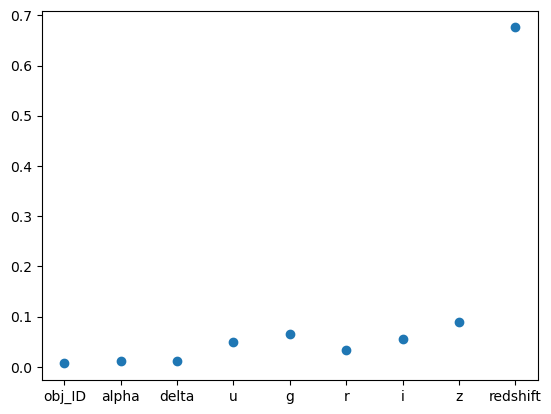

In [9]:
from sklearn.ensemble import RandomForestClassifier

mod = RandomForestClassifier(bootstrap=True)
mod.fit(X_tr,y_tr)

plt.scatter(X_tr.columns, mod.feature_importances_)

On remarque que l'on peut regrouper nos variables en fonction de categories d'importance. 

D'une part, on remarque de façon nette, que redshift est sans aucun doute la variable a plus forte importance, et donc notre modèle fait maison est assez bien calibré. 
Au contraire, on constate que les varoables obj_ID, alpha,delta ont une importante assez faible et uniforme. 

Enfin, on remarque que les variables (u, g, r, i et z) ont de façon assez uniforme la même importance. Or, on a vu en cours, que cette mesure d'importance pouvait porter a malinterpretation au niveau de variables portant le même type d'information. En effet, des variables portant la même information ont souvent une importance unforme et basse. Alors que l'information apportée par ce groupe de variables peut s'avérée clée au niveau de la prédiction. 

Dans la suite, on va choisir l'une de ces variables pour entrainer un modele de une classification que l'on ajoutera à celui fait maison.
On choisira z car c'est la variable parmi les elements de ce groupe de variable avec la plus forte importance.  

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


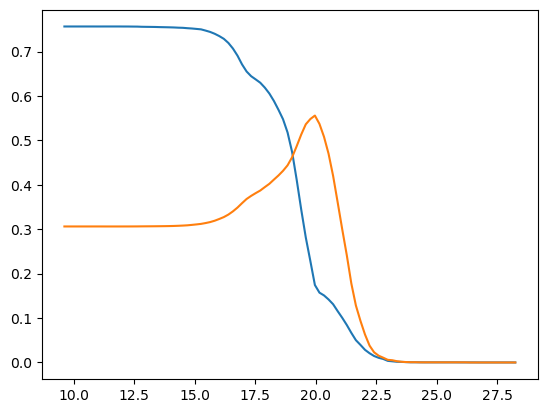

In [289]:
seuil_0z,seuil_2z = choix_seuils(X_tr,y_tr,5,100, "z")
new_predz = Label_Encode(y_tr, pd.DataFrame(predict(seuil_0z,seuil_2z, X_te, "z")))

On etudie sa performance

In [294]:
c_mz = confusion_matrix(y_te.to_numpy(), new_predz) / confusion_matrix(y_te.to_numpy(), new_predz).sum()
print("Matrice confusion: ")
print(c_mz)
#print("")
#taux_mal_classesz = c_mz[0,1:2] + c_mz[1,0] + c_mz[1,2] + c_mz[2,0:1] + c_mz[2,0:1]
#print("taux_mal_classes: ", taux_mal_classesz)
#print("")
print("f1_score: ", f1_score(y_te.to_numpy(), new_predz,average="weighted"))

Matrice confusion: 
[[5.42183335e-01 0.00000000e+00 7.14451269e-02]
 [1.66009966e-01 5.79441418e-05 4.40375478e-02]
 [6.30432263e-02 0.00000000e+00 1.13222853e-01]]
f1_score:  0.579156361450141


On constate que: 

- Notre modèle ne se trompe pas lors des predictions de 1. En effet quand notre modèle predit la label 1, il ne s'agit pas d'un vrai 0 ou 2. 
- Confusions: 
    - la plus importante: Pred: 0 alors que True: 1.

Ceci pourrait être du a une sous estimation de la classe 1.   

In [291]:
print(c_m)

[[5.67099316e-01 3.58674238e-02 1.06617221e-02]
 [0.00000000e+00 2.10105458e-01 0.00000000e+00]
 [3.52879824e-02 5.79441418e-05 1.40920153e-01]]


On constate que: 

-Notre modèle predit correctement le label 1.En effet, notre modèle ne choisi pas le label 0 ou 2 quand il s'agit d'un 1.  
- Confusions: 
    - la plus importante: Pred: 0 alors que True: 2.

Ceci pourrait être du a une sur-estimation de la classe 1.   

In [296]:
def tirage(p,pred1,pred2):
    res = pred1
    idx = np.intersect1d( np.where(pred1!=pred2)[0], np.where(pred2==1)[0])
    for i in idx: 
        if np.random.binomial(1,p)==1: 
            res[i] = pred2[i]
    return res

def melange(folds,Xtr,ytr, var1, var2, seuil1, seuil2):
    X, y = CV_rep(Xtr, ytr, folds)
    probas = np.linspace(0.01,0.99,20)
    results = np.zeros((folds,len(probas)))

    for i in range(folds): 
        Xr = X[i]
        yr=y[i].to_numpy()
        for j,p in enumerate(probas): 
            p1 = Label_Encode(yr, pd.DataFrame(predict(seuil1[0],seuil1[1], Xr, var1)))
            p2 = Label_Encode(yr, pd.DataFrame(predict(seuil2[0],seuil2[1], Xr, var2)))
            pred = tirage(p,p1,p2)
            results[i,j] = f1_score(yr,pred, average="weighted")
    
    return probas[np.where(results.mean(axis=0)==results.mean(axis=0).max())[0][0]]


def pred_mel(ytr,Xte, seuil1, seuil2, var1, var2, p): 
    p1 = Label_Encode(ytr, pd.DataFrame(predict(seuil1[0],seuil1[1], Xte, var1)))
    p2 = Label_Encode(ytr, pd.DataFrame(predict(seuil2[0],seuil2[1], Xte, var2)))
    return tirage(p,p1,p2)

In [297]:
melange(5,X_tr,y_tr, "redshift", "z",[seuil_0,seuil_2], [seuil_0z,seuil_2z])

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt

0.01

Méthodes basées sur redshift et z

In [ ]:
c_m = confusion_matrix(y_te.to_numpy(), new_pred) / confusion_matrix(y_te.to_numpy(), new_pred).sum()
print("Matrice confusion: ")
print(c_m)
print("")

Matrice confusion: 
[[5.67099316e-01 3.58674238e-02 1.06617221e-02]
 [0.00000000e+00 2.10105458e-01 0.00000000e+00]
 [3.52879824e-02 5.79441418e-05 1.40920153e-01]]



In [ ]:
c_mlda = confusion_matrix(y_te.to_numpy(), pred_lda) / confusion_matrix(y_te.to_numpy(), pred_lda).sum()
print("Matrice confusion: ")
print(c_mlda)

Matrice confusion: 
[[0.41221463 0.12689767 0.07451617]
 [0.12556496 0.05371422 0.03082628]
 [0.07752926 0.03314405 0.06559277]]


In [176]:
X_test = pd.read_csv("stars_test_new.csv")

In [323]:
XTR = X_tr[["redshift", "z"]]
XTE = X_te[["redshift",  "z"]]

In [340]:
from sklearn.neighbors import KNeighborsClassifier

lda = KNeighborsClassifier()
lda.fit(XTR, y_tr)
pred_lda = lda.predict(XTE)

print(f1_score(y_te.to_numpy(), pred_lda, average="weighted"))

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9423878077864581


In [348]:
def tirage(p,pred1,pred2):
    res = pred1
    idx = np.where(pred1!=pred2)[0]
    #np.intersect1d(np.where(pred2==1)[0],np.where(pred1!=pred2)[0])
    for i in idx: 
        if np.random.binomial(1,p)==1: 
            res[i] = pred2[i]
    return res

def melange(folds,Xtr,ytr, var1, seuil1, model2):
    X, y = CV_rep(Xtr, ytr, folds)
    probas = np.linspace(0.00,1,20)
    results = np.zeros((folds,len(probas)))

    for i in range(folds): 
        Xr = X[i]
        yr=y[i].to_numpy()
        p1 = Label_Encode(yr, pd.DataFrame(predict(seuil1[0],seuil1[1], Xr, var1)))
        p2 = Label_Encode(yr, pd.DataFrame(model2.predict(Xr[["z","redshift"]])))
        for j,p in enumerate(probas): 
            pred = tirage(p,p1,p2)
            results[i,j] = f1_score(yr,pred, average="weighted")
    
    return probas[np.where(results.mean(axis=0)==results.mean(axis=0).max())[0][0]]


def pred_mel(ytr,Xte, p1, p2, p): 
    p1 = Label_Encode(ytr, pd.DataFrame(p1))
    p2 = Label_Encode(ytr, pd.DataFrame(p2))
    return tirage(p,p1,p2)

In [342]:
prob = melange(5,X_tr,y_tr, "redshift", [seuil_0,seuil_2], lda)

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt

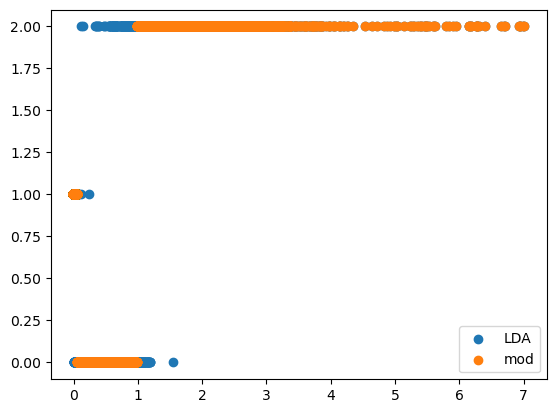

In [343]:
plt.scatter(X_te[["redshift"]],pred_lda, label="LDA")
plt.scatter(X_te[["redshift"]],new_pred, label="mod")

plt.legend()

In [344]:
prob

0.8421052631578947

In [345]:
new = pred_mel(y,X_test, new_pred, pred_lda, prob)

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt

In [346]:
print("f1_score: ", f1_score(y_te.to_numpy(), new,average="weighted"))

f1_score:  0.9385972959657284


/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/laurafuentesvicente/opt/an

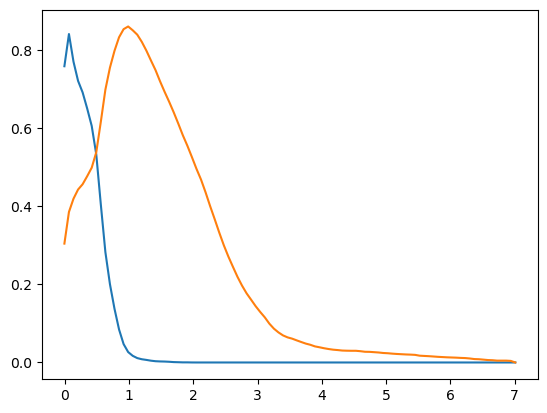

In [352]:
seuil_0,seuil_2 = choix_seuils(X,y,5,100, "redshift")
new_pred = Label_Encode(y,pd.DataFrame(predict(seuil_0,seuil_2, X_test, "redshift")))

from sklearn.neighbors import KNeighborsClassifier
lda = KNeighborsClassifier().fit(X[["z", "redshift"]], y)
pred_lda = lda.predict(X_test[["z","redshift"]])


prob = melange(5,X,y, "redshift", [seuil_0,seuil_2], lda)
new = pred_mel(y,X_test, new_pred, pred_lda, prob)


In [355]:
data = np.column_stack((X_test["obj_ID"].to_numpy(), new))
    # Nommez les colonnes
column_names = ['obj_ID', 'label']
    # Spécifiez le nom du fichier CSV de sortie
csv_filename = 'submissions_C/'+"melange_KNN_met_faitmaison"+'_'+"2310"+'.csv'
    # Ouvrez le fichier CSV en mode écriture et écrivez les données
with open(csv_filename, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
        # Écrivez les noms des colonnes
    writer.writerow(column_names)
        # Écrivez les données
    writer.writerows(data)

array([1, 0, 1, ..., 0, 0, 1])